This notebook evaluates the fitness of Inflight Fulfillment against historical component-poundage estimates. 

Predictions are evaluated on 

1. Directional correctness - is there a shortfall when one is predicted?
1. Relative magnitude - what is the prediction error as a function of mass
1. Absolute magnitude - what is the total poundage of error
1. Instance of 

Additionally, as predictions are evaluated for dates several weeks into the future, we'll evaluate predictions up to T+5

# Imports, etc.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import datetime 
import numpy as np
import os
from plotnine import *

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import pandas as pd
pd.set_option('display.max_rows',500)

In [3]:
import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

In [4]:
from sklearn.metrics import confusion_matrix

In [5]:
def confusion_accuracy(sub_df):
    
    cm = confusion_matrix(y_true = sub_df['y_true'], y_pred=sub_df['y_pred'])
    
    accuracy = np.diagonal(cm / (cm.sum(axis=None))).sum()
    
    return pd.DataFrame([[accuracy, len(sub_df)]], columns=['accuracy','n'])

# Data

Recall that as we don't historically record shortfall in terms of component-poundage, this is not truly "actual" data but rather a reconstruction.

In [7]:
qry = """
    select * 
    from predict.m_inflight_fulfillment
    limit 10
"""
df = pd.read_sql(qry,conn)

In [8]:
df.transpose()

,0,1,2,3,4,5,6,7,8,9
FARM_ID,1,1,2,2,2,2,2,2,2,2
FACT_DATE,2022-02-04,2021-02-09,2022-01-27,2022-01-27,2022-01-27,2022-01-27,2022-01-27,2022-01-27,2022-01-27,2022-01-27
REFERENCE_DATE,None,None,2022-01-27,2022-01-27,2022-01-26,2022-01-26,2022-01-25,2022-01-25,2022-01-24,2022-01-24
COMPONENT_ID,47,28,10,10,10,10,10,10,10,10
COMPONENT_NAME,Dandelion,Purple Mustard,Green Romaine,Green Romaine,Green Romaine,Green Romaine,Green Romaine,Green Romaine,Green Romaine,Green Romaine
CASE_INVENTORY_LBS,18,90,268.455,268.455,268.455,268.455,268.455,268.455,268.455,268.455
BIN_INVENTORY_LBS,NaN,43.3032,112.512,112.512,112.512,112.512,112.512,112.512,112.512,112.512
RECENT_HARVEST_TO_PACK_PCT,NaN,NaN,79.5068,79.5068,79.5068,79.5068,79.5068,79.5068,79.5068,79.5068
BIN_INVENTORY_PACKED_ESTIMATION_LBS,NaN,NaN,89.4543,89.4543,89.4543,89.4543,89.4543,89.4543,89.4543,89.4543
PACKED_LBS,NaN,8.4375,99.4699,99.4699,99.4699,99.4699,99.4699,99.4699,99.4699,99.4699


In [ ]:
df

In [ ]:
## Inflight Fulfillment Predictions

In [9]:
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'
qry = f"""
    select *, 
      concat('Farm ',farm_id) as farm_str
    from predict.m_inflight_fulfillment
    where fact_date between '{START_DATE}' and '{END_DATE}'
      and is_backfill = true
      and code_version = '1.0.4'
    qualify rank() over (partition by farm_id, component_id, fact_date, prediction_days_ahead order by computed_at desc) = 1
"""

data_df = pd.read_sql(qry,conn)

# Analysis

## Directional Correctness

### Overall

In [10]:
N_PREDICTION_DAYS_AHEAD = 5

directional_confusion_matrix = (
    data_df
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    .filter(items=['FARM_ID',
                   'FACT_DATE',
                   'COMPONENT_ID',
                   'COMPONENT_NAME',
                   'ANTICIPATED_SHORTFALL_LBS',
                   'PREDICTED_SHORTFALL_LBS_Q10',
                   'PREDICTED_SHORTFALL_LBS_Q50',
                   'PREDICTED_SHORTFALL_LBS_Q90'
                  ])
    .assign(anticipated_sign = lambda x: x['ANTICIPATED_SHORTFALL_LBS'].apply(np.sign))
    .assign(predicted_q50_sign = lambda x: x['PREDICTED_SHORTFALL_LBS_Q50'].apply(np.sign))
    
    .pipe(lambda df: confusion_matrix(y_true=df['anticipated_sign'],y_pred=df['predicted_q50_sign']))
)

directional_confusion_matrix

array([[7221,  310,  961],
       [ 766, 3571, 1195],
       [2647,  159, 2610]])

In [11]:
(directional_confusion_matrix / (directional_confusion_matrix.sum(axis=None))).round(2)

array([[0.37, 0.02, 0.05],
       [0.04, 0.18, 0.06],
       [0.14, 0.01, 0.13]])

In [12]:
# Accuracy (sum of the diagonal)
np.diagonal(directional_confusion_matrix / (directional_confusion_matrix.sum(axis=None))).sum()

0.68940329218107

### Overall By Farm, Component and Prediction Days Ahead

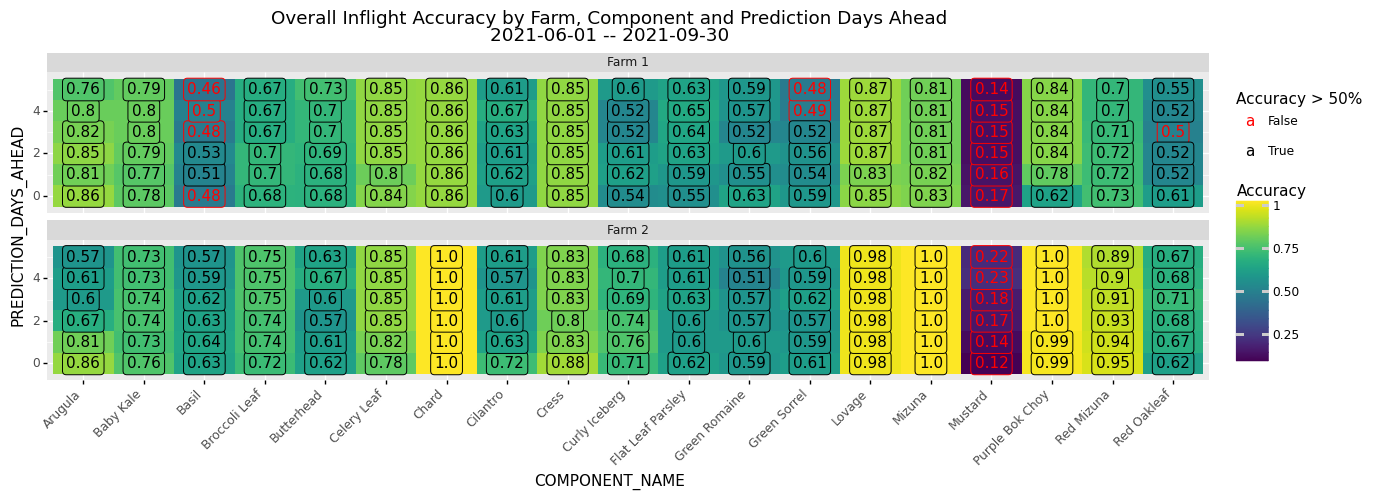

<ggplot: (359954893)>

In [14]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 5
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    
    .assign(y_true = lambda x: x['ANTICIPATED_SHORTFALL_LBS'].apply(np.sign))
    .assign(y_pred = lambda x: x['PREDICTED_SHORTFALL_LBS_Q50'].apply(np.sign))
    
    .groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])
    .apply(confusion_accuracy)
    .reset_index()
    .query('n > @DAYS_OBSERVED')
    
    .assign(accuracy_gr_50 = lambda x: x['accuracy'] > .5)
    .assign(accuracy_2 = lambda x: np.round(x['accuracy'],2).astype(str))
    
    .pipe(lambda df: ggplot(df, aes(x='COMPONENT_NAME',y='PREDICTION_DAYS_AHEAD', fill='accuracy', label='accuracy_2'))
         + geom_tile()
         + geom_label(aes(color='accuracy_gr_50'))
         + scale_color_manual(values=['red','black'])
         + facet_wrap('FARM_STR',ncol=1)
         + theme(figure_size=(15,4), axis_text_x=element_text(hjust=1,rotation=45)))
         + labs(color='Accuracy > 50%', fill='Accuracy')
         + ggtitle(f"Overall Inflight Accuracy by Farm, Component and Prediction Days Ahead\n{START_DATE} -- {END_DATE}")
)

### Identify Shortfalls (Recall)

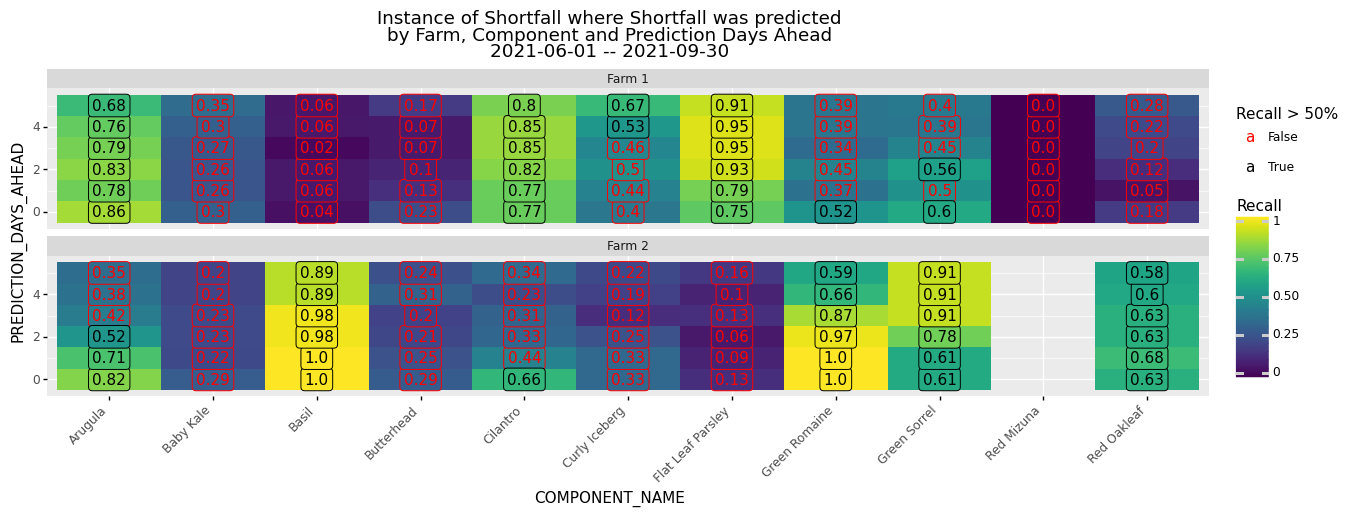

<ggplot: (361417957)>

In [15]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 5
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    
    .assign(y_true = lambda x: x['ANTICIPATED_SHORTFALL_LBS'].apply(np.sign))
    .assign(y_pred = lambda x: x['PREDICTED_SHORTFALL_LBS_Q50'].apply(np.sign) > 0)
    
    .query('y_true > 0')
    .groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])
    .agg(recall = pd.NamedAgg('y_pred','mean'),
         n      = pd.NamedAgg('y_pred','size'))
    .reset_index()
    .query('n > @DAYS_OBSERVED')
    
    .assign(recall_gr_50 = lambda x: x['recall'] > .5)
    .assign(recall_2 = lambda x: np.round(x['recall'],2).astype(str))
    
    .pipe(lambda df: ggplot(df, aes(x='COMPONENT_NAME',y='PREDICTION_DAYS_AHEAD', fill='recall', label='recall_2'))
         + geom_tile()
         + geom_label(aes(color='recall_gr_50'))
         + scale_color_manual(values=['red','black'])
         + facet_wrap('FARM_STR',ncol=1)
         + theme(figure_size=(15,4), axis_text_x=element_text(hjust=1,rotation=45)))
         + labs(color='Recall > 50%', fill='Recall')
         + ggtitle(f"Instance of Shortfall where Shortfall was predicted\nby Farm, Component and Prediction Days Ahead\n{START_DATE} -- {END_DATE}")
)

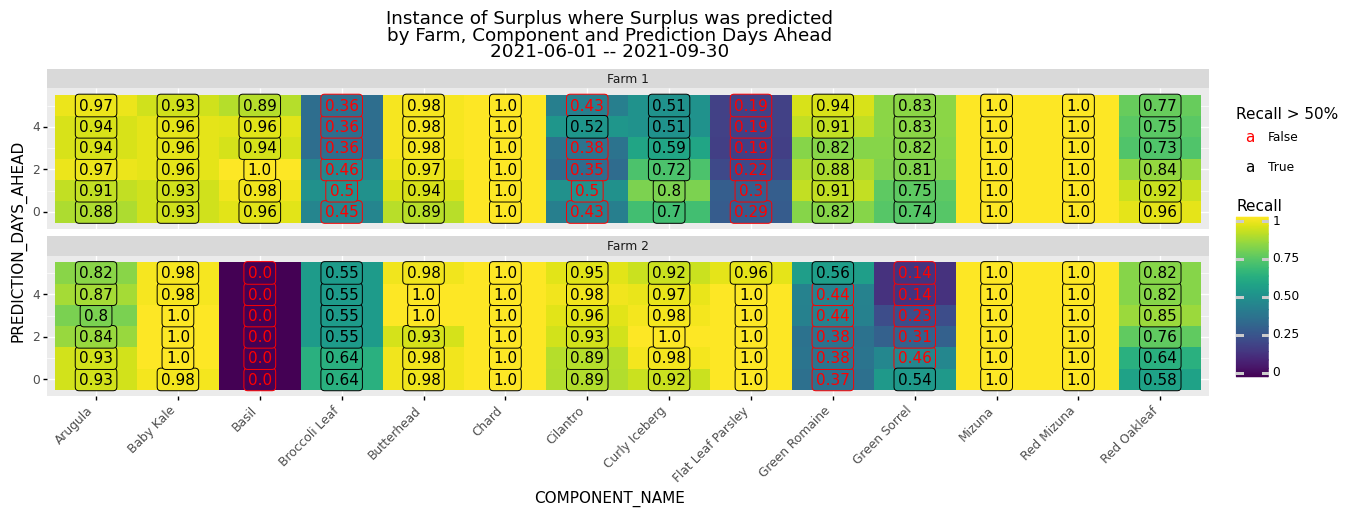

<ggplot: (361411539)>

In [16]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 5
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    
    .assign(y_true = lambda x: x['ANTICIPATED_SHORTFALL_LBS'].apply(np.sign))
    .assign(y_pred = lambda x: x['PREDICTED_SHORTFALL_LBS_Q50'].apply(np.sign) < 0)
    
    .query('y_true < 0')
    .groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])
    .agg(recall = pd.NamedAgg('y_pred','mean'),
         n      = pd.NamedAgg('y_pred','size'))
    .reset_index()
    .query('n > @DAYS_OBSERVED')
    
    .assign(recall_gr_50 = lambda x: x['recall'] > .5)
    .assign(recall_2 = lambda x: np.round(x['recall'],2).astype(str))
    
    .pipe(lambda df: ggplot(df, aes(x='COMPONENT_NAME',y='PREDICTION_DAYS_AHEAD', fill='recall', label='recall_2'))
         + geom_tile()
         + geom_label(aes(color='recall_gr_50'))
         + scale_color_manual(values=['red','black'])
         + facet_wrap('FARM_STR',ncol=1)
         + theme(figure_size=(15,4), axis_text_x=element_text(hjust=1,rotation=45)))
         + labs(color='Recall > 50%', fill='Recall')
         + ggtitle(f"Instance of Surplus where Surplus was predicted\nby Farm, Component and Prediction Days Ahead\n{START_DATE} -- {END_DATE}")
)

## Relative Magnitude

In [17]:
def round_up(x):
    if x == 0:
        return 1
    elif abs(x) > 0 and abs(x) < 1:
        return 1*np.sign(x)
    else:
        return x

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 3875 rows containing non-finite values.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


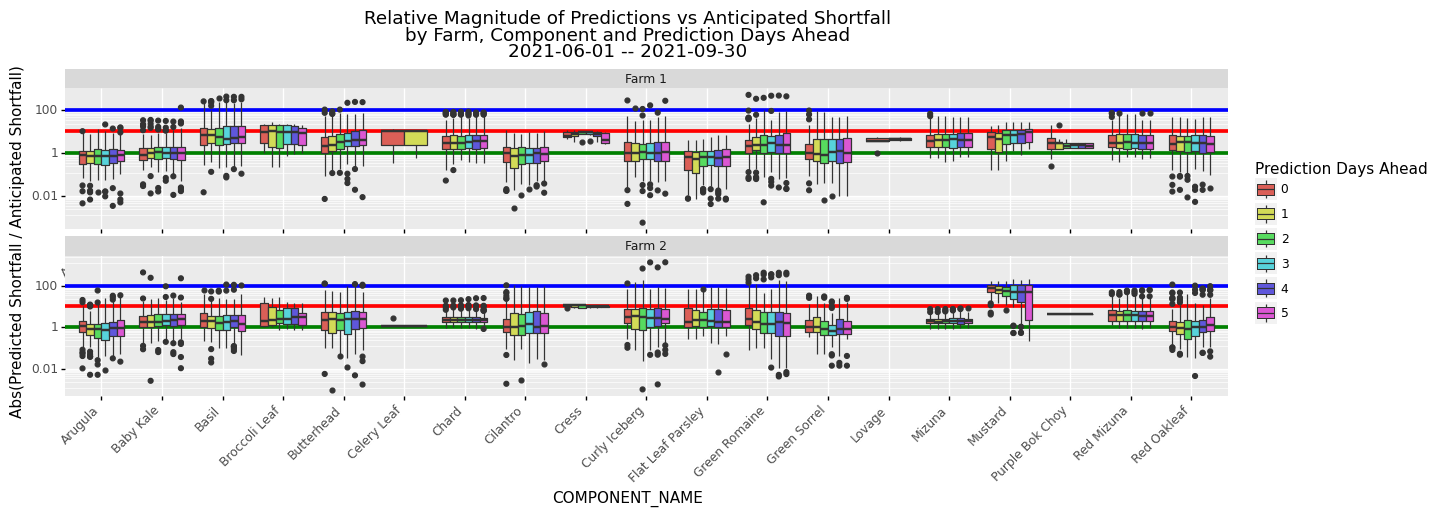

<ggplot: (364722339)>

In [18]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 5
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    
    .assign(n = lambda df: df.groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])['FARM_STR'].transform('size'))
    .assign(pred_str = lambda x: x['PREDICTION_DAYS_AHEAD'].astype(str))
    
    # Where the anticipated shortfall is between 0 and 1, make it 1 
    .assign(ANTICIPATED_SHORTFALL_CORRECTED = lambda x: x['ANTICIPATED_SHORTFALL_LBS'].apply(round_up))
    .assign(relative_magnitude = lambda x: np.abs(x['PREDICTED_SHORTFALL_LBS_Q50'] / (x['ANTICIPATED_SHORTFALL_CORRECTED']))) 
    
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    .query('n > @DAYS_OBSERVED')  

    .reset_index()

    .pipe(lambda df: ggplot(df, aes(x='COMPONENT_NAME',y='relative_magnitude',fill='pred_str'))
          + geom_hline(yintercept=1,color='green',size=1.5)
          + geom_hline(yintercept=10,color='red',size=1.5)
          + geom_hline(yintercept=100,color='blue',size=1.5)
          + geom_boxplot(position='dodge')


          + scale_y_log10()
          + labs(y="Abs(Predicted Shortfall / Anticipated Shortfall)", fill='Prediction Days Ahead')
          + facet_wrap('FARM_STR',ncol=1,scales='free')
          + theme(figure_size=(15,4), axis_text_x=element_text(hjust=1,rotation=45))
          
          + ggtitle(f"Relative Magnitude of Predictions vs Anticipated Shortfall\nby Farm, Component and Prediction Days Ahead\n{START_DATE} -- {END_DATE}")
         )

)

## Absolute Magnitude

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


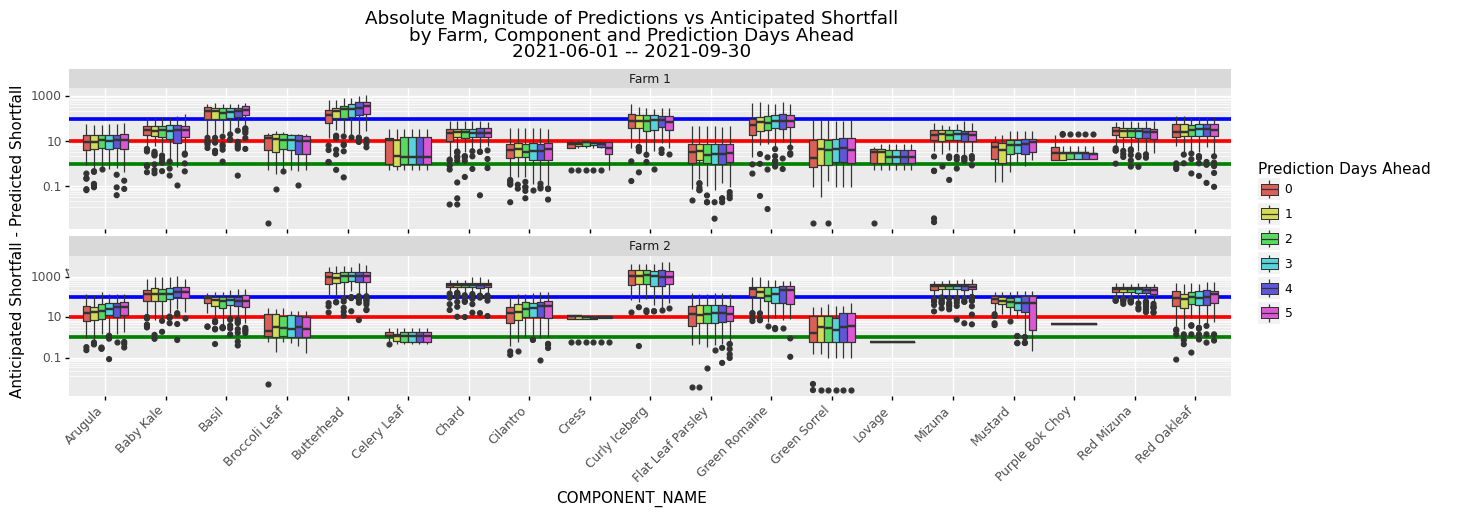

<ggplot: (365801735)>

In [22]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 5
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    
    .assign(n = lambda df: df.groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])['FARM_STR'].transform('size'))
    .assign(pred_str = lambda x: x['PREDICTION_DAYS_AHEAD'].astype(str))
    
    .assign(absolute_magnitude = lambda x: np.abs(x['ANTICIPATED_SHORTFALL_LBS'] - x['PREDICTED_SHORTFALL_LBS_Q50']))
    
    
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    .query('n > @DAYS_OBSERVED')  

    .reset_index()
    
    # clear a handful of outliers to make F2 display better
    .query('absolute_magnitude > 1e-6')

    .pipe(lambda df: ggplot(df, aes(x='COMPONENT_NAME',y='absolute_magnitude',fill='pred_str'))
          + geom_hline(yintercept=1,color='green',size=1.5)
          + geom_hline(yintercept=10,color='red',size=1.5)
          + geom_hline(yintercept=100,color='blue',size=1.5)
          + geom_boxplot(position='dodge')

          + scale_y_log10()
          + labs(y="Anticipated Shortfall - Predicted Shortfall", fill='Prediction Days Ahead')
          + facet_wrap('FARM_STR',ncol=1,scales='free')
          + theme(figure_size=(15,4), axis_text_x=element_text(hjust=1,rotation=45))
          
          + ggtitle(f"Absolute Magnitude of Predictions vs Anticipated Shortfall\nby Farm, Component and Prediction Days Ahead\n{START_DATE} -- {END_DATE}")
         )

)

In [20]:
(
    data_df
    
    .assign(n = lambda df: df.groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])['FARM_STR'].transform('size'))
    .assign(pred_str = lambda x: x['PREDICTION_DAYS_AHEAD'].astype(str))
    
    .assign(absolute_magnitude = lambda x: np.abs(x['ANTICIPATED_SHORTFALL_LBS'] - x['PREDICTED_SHORTFALL_LBS_Q50']))
    
    
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    .query('n > @DAYS_OBSERVED')  

    .reset_index()
    .sort_values('absolute_magnitude',ascending=False)
    .drop(['index','GIT_SHA','CODE_VERSION','IS_BACKFILL','COMPUTED_AT_LOCAL','MESSAGE_ID','SHORTFALL_PROBABILITY'],axis=1)
).head().T

,10852,4074,14120,18122,14910
FARM_ID,2,2,2,2,2
FACT_DATE,2021-06-06,2021-06-06,2021-06-11,2021-06-11,2021-08-30
REFERENCE_DATE,2021-06-02,2021-06-01,2021-06-06,2021-06-07,2021-08-26
COMPONENT_ID,14,14,14,14,12
COMPONENT_NAME,Curly Iceberg,Curly Iceberg,Curly Iceberg,Curly Iceberg,Butterhead
CASE_INVENTORY_LBS,1254.69,1254.69,660.795,660.795,1500.09
BIN_INVENTORY_LBS,948.234,948.234,394.058,394.058,1599.73
RECENT_HARVEST_TO_PACK_PCT,69.9977,69.9977,69.7403,69.7403,65.5613
BIN_INVENTORY_PACKED_ESTIMATION_LBS,663.742,663.742,274.817,274.817,1048.8
PACKED_LBS,886.279,886.279,741.557,741.557,1059.82


In [21]:
qry = """
    select * from warehouse.v_inflight_fulfillment_states
    where DELIVERY_SCHEDULED_ON = '2021-07-23'
    and farm_id = 2
    and component_id = 14
    limit 5
"""
pd.read_sql(qry,conn).T

,0,1,2,3,4
DELIVERY_SCHEDULED_ON,2021-07-23,2021-07-23,2021-07-23,2021-07-23,2021-07-23
HARVEST_SCHEDULED_ON,2021-07-22,2021-07-22,2021-07-22,2021-07-22,2021-07-22
FARM_ID,2,2,2,2,2
COMPONENT_ID,14,14,14,14,14
HARVEST_PDF_LESS_THAN_ZERO,0,0,0,0,0
HARVEST_Q10,648,423.69,693.81,640.48,624.85
HARVEST_Q50,704.93,481.07,765.53,714.05,691.57
HARVEST_Q90,761.86,538.45,837.26,787.63,758.3
HARVEST_MEAN,704.93,481.07,765.53,714.05,691.57
HARVEST_SKETCH,"N(704.93,44.42)","N(481.07,44.77)","N(765.53,55.97)","N(714.05,57.41)","N(691.57,52.07)"
